In [1]:
from gibbs import *
import numpy as np
import pystan
from data_pertub import *
from mcmc_plot import *
from PPCA_pystan import *
import warnings
from PPCA_pystan import *
warnings.filterwarnings("ignore")

##  1. Generate Data

In [2]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])

In [3]:
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])


d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epsilon = float(data_config['epsilon'])
beta_vj = epsilon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                         'a_sigma2': a_sigma2,
                         'a_vj': a_vj,
                         'beta_vj': beta_vj
                         })

true sigma2_star is 0.004800486930934525
true v_j list is [0.60102721]


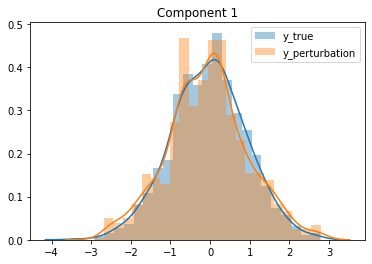

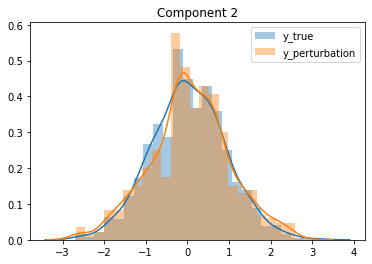

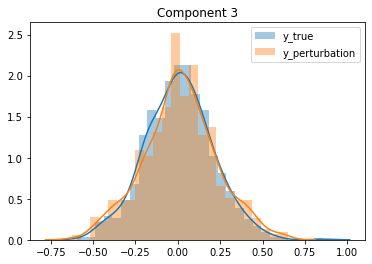

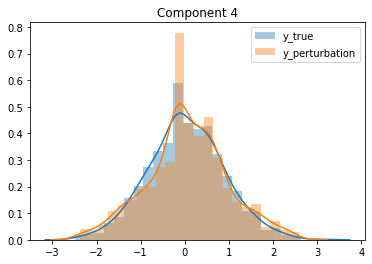

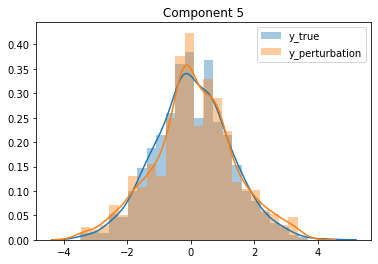

In [4]:
y_true, W_star, Z_star, sigma2_star, v_star_list = forward_sample(
    d, q_star, n_sample, prior_param_true, verbose=True)
y_perturbation = sample_perturbation2(y_true, n_sample, alpha)
#y_perturbation = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)

for j in range(d):
    sns.distplot(y_true[j, :], label='y_true')
    sns.distplot(y_perturbation[j, :], label='y_perturbation')
    plt.legend()
    plt.title('Component ' + str(j+1))
    plt.show()

In [5]:
X = y_true

## 2. MCMC Prior

In [6]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [7]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q)
epsilon = float(mcmc_setup['epsilon'])
beta_vj = epsilon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': beta_sigma2,
                         'a_sigma2': a_sigma2,
                         'a_vj': a_vj,
                         'beta_vj': beta_vj
                         })

In [8]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

## 3. MCMC Gibbs

In [9]:
mcmc_list = []
for sub_chains in range(n_chains):
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, n_sample]),
                      "sigma20": sigma2_star,
                      # "w0": W_star,
                      'w0': np.random.normal(0, 1, [d, q]),
                      # 'v0': np.repeat(v_star_list, q).ravel(),
                      # 'v0': sorted(v_star_list)})
                      'v0': sorted(1/np.random.gamma(a_vj, 1 / beta_vj))})

    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi=1)
    mcmc_list.append(inference.gibbs_result())

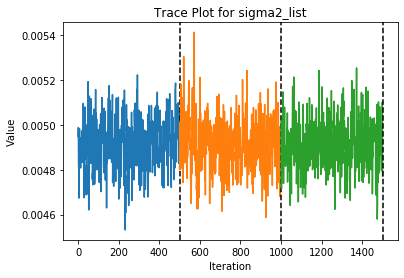

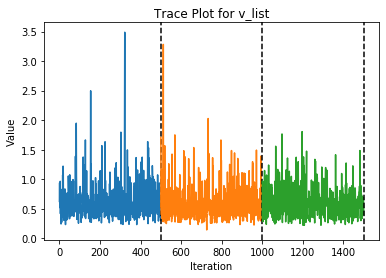

In [10]:
var_list = ['sigma2_list', 'v_list']
trace_plot(mcmc_list, var_list)

In [11]:
print(sigma2_star)

0.004800486930934525


In [12]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
v_list = get_trace_list(mcmc_list, 'v_list')

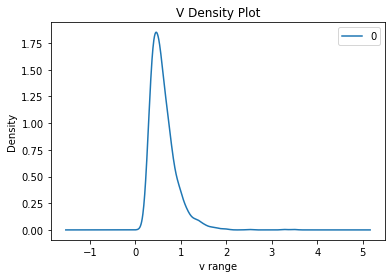

In [13]:
v_table = plot_v_density(v_list)

In [14]:
np.mean(v_list, axis=1)

array([[0.63468467],
       [0.60061832],
       [0.60565208]])

In [15]:
print(v_star_list)

[0.60102721]


## 4. MCMC Pystan Ordered $V_j$

In [16]:
init_list = []
for i_ in range(n_chains):
    temp_dict = {
        # 'v': np.repeat(v_star_list, q).ravel(),
         'v': sorted(v_star_list),
       # 'v': sorted(1/np.random.gamma(a_vj, 1 / beta_vj)),
        'sigma2': sigma2_star,
         "w0": W_star.T

    }
    init_list.append(temp_dict)

In [17]:
ppca_code = """
data { 
    int D; //number of dimensions
    int N; //number of data
    int Q; //number of principle components
//    matrix[N,D] x; // data
    vector[D] x[N]; //data
    real a_vj; // w_j prior 
    real epsilon;// w_j mean
    real xi; // power parameter
    real a_sigma2; // sigma2 prior 
    real beta_sigma2;// sigma2 mean
}

transformed data {
    matrix[D,D] S;
    S = x[1] * x[1]';
    
    for (n in 2:N){
    S += x[n] * x[n]';
    }
    S = S/N;
    
}
parameters {
    ordered[Q] v; // v_j
    real<lower=0> sigma2; //data sigma2
    matrix[Q,D] W; //projection matrix
}
model {
    matrix[D,D] C; //covaraince matrix
    for(j in 1:Q){
        v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
        W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
        }
        
    sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);
    
    C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));    

    target += - N/2 *(log_determinant (C) + trace( C\S));
}

generated quantities {
    vector[D] y_hat[N]; //predictive
    for (n in 1:N) {
        y_hat[n] = multi_normal_rng(rep_vector(0,D), crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D)));
    }
}

"""

In [18]:
sm = pystan.StanModel(model_code=ppca_code)  # code compile

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e0f138eee59a411e3db008769f1e1df3 NOW.


In [19]:
print(sm.model_code)


data { 
    int D; //number of dimensions
    int N; //number of data
    int Q; //number of principle components
//    matrix[N,D] x; // data
    vector[D] x[N]; //data
    real a_vj; // w_j prior 
    real epsilon;// w_j mean
    real xi; // power parameter
    real a_sigma2; // sigma2 prior 
    real beta_sigma2;// sigma2 mean
}

transformed data {
    matrix[D,D] S;
    S = x[1] * x[1]';
    
    for (n in 2:N){
    S += x[n] * x[n]';
    }
    S = S/N;
    
}
parameters {
    ordered[Q] v; // v_j
    real<lower=0> sigma2; //data sigma2
    matrix[Q,D] W; //projection matrix
}
model {
    matrix[D,D] C; //covaraince matrix
    for(j in 1:Q){
        v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
        W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
        }
        
    sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);
    
    C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));    

    target += - N/2 *(log_determinant (C) + trace( C\S));
}

generated

In [20]:
ppca_dat_standard = {'D': d,
                     'N': n_sample,
                     'Q': q,
                     'x': X.reshape([n_sample, d]),
                     'xi': 1,
                     'a_vj': a_vj[0],
                     'epsilon': epsilon,
                     'a_sigma2': a_sigma2,
                     'beta_sigma2': beta_sigma2
                     }

In [21]:
fit_standard = sm.sampling(data=ppca_dat_standard,
                           iter=iterations, chains=n_chains, init=init_list, seed=1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v[0]    0.284  0.139   0.109    0.517      0.007    0.006     390.0   313.0   
sigma2  0.722  0.016   0.695    0.751      0.000    0.000    1564.0  1560.0   
W[0,0]  0.136  0.392  -0.468    0.488      0.223    0.176       3.0     3.0   
W[0,1]  0.121  0.352  -0.440    0.438      0.200    0.157       3.0     3.0   
W[0,2] -0.017  0.062  -0.131    0.099      0.022    0.016       8.0     8.0   
W[0,3] -0.043  0.127  -0.249    0.187      0.062    0.047       4.0     4.0   
W[0,4]  0.021  0.067  -0.100    0.138      0.026    0.019       7.0     7.0   

        ess_bulk  ess_tail  r_hat  
v[0]       673.0     494.0   1.01  
sigma2    1604.0    1225.0   1.00  
W[0,0]       5.0      40.0   1.66  
W[0,1]       5.0      42.0   1.66  
W[0,2]       8.0      46.0   1.27  
W[0,3]       5.0      45.0   1.62  
W[0,4]       7.0      61.0   1.36  


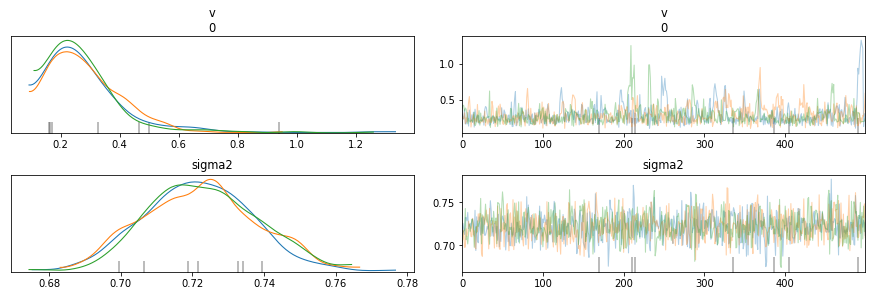

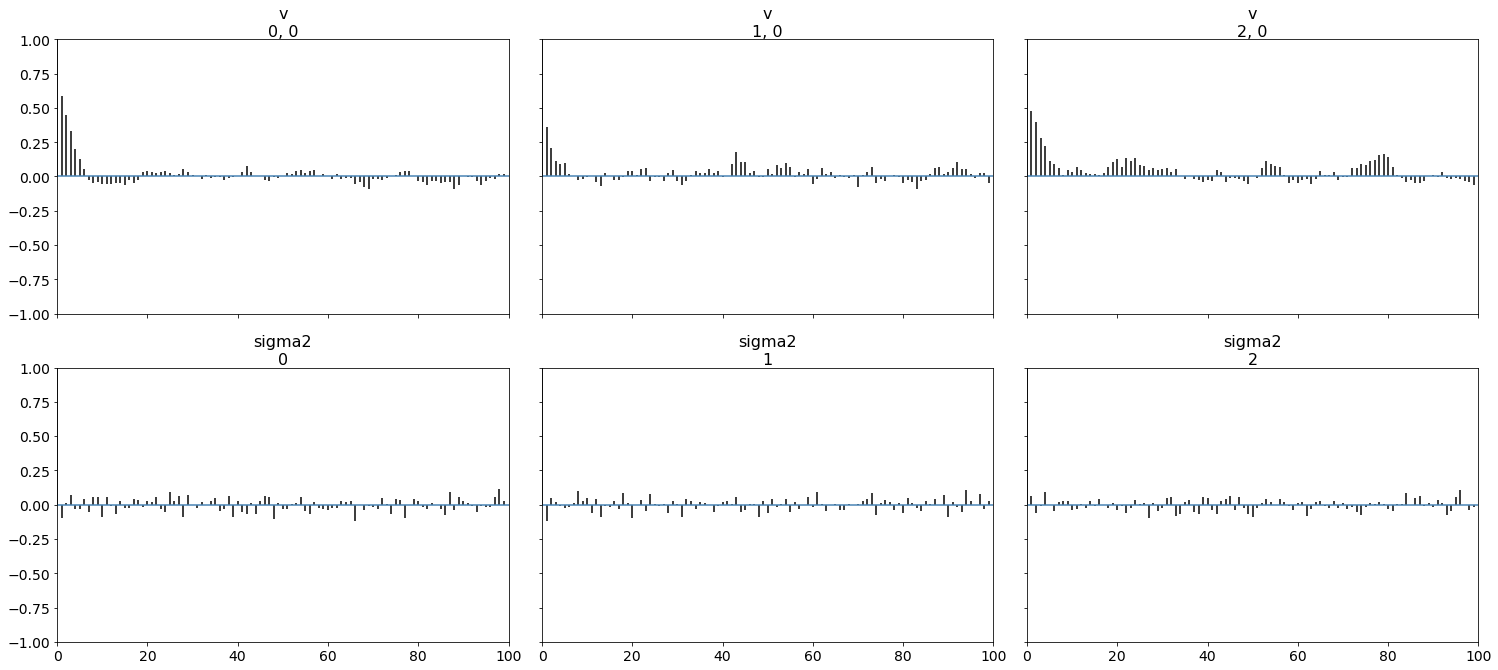

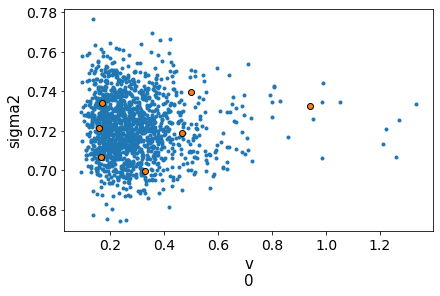

In [22]:
az_v_sigma2_plot(fit_standard)

In [23]:
print(v_star_list)

[0.60102721]


In [24]:
sigma2_star

0.004800486930934525

## 5. MCMC Pystan Using multi_normal_lpdf

In [25]:
ppca_code2 = """
data { 
    int D; //number of dimensions
    int N; //number of data
    int Q; //number of principle components
    vector[D] x[N]; //data
    real a_vj; // w_j prior 
    real epsilon;// w_j mean
    real xi; // power parameter
    real a_sigma2; // sigma2 prior 
    real beta_sigma2;// sigma2 mean
 }

parameters {
    ordered[Q] v; // v_j
    real<lower=0> sigma2; //data sigma2
    matrix[Q,D] W; //projection matrix
}
model {
    matrix[D,D] C; //covaraince matrix

    for(j in 1:Q){
        v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
        W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
        }
    sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);

    C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));

    for(n in 1:N){
    target += xi * multi_normal_lpdf(x[n]|rep_vector(0,D), C);
    }
}

generated quantities {
vector[D] y_hat[N]; //predictive
    for (n in 1:N) {
        y_hat[n] = multi_normal_rng(rep_vector(0,D), crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D)));
    }
}

"""

In [26]:
sm2 = pystan.StanModel(model_code=ppca_code2)  # code compile

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6e50d44f3854e0483cf486ff5fee78f0 NOW.


In [27]:
fit_standard2 = sm2.sampling(
    data=ppca_dat_standard, iter=iterations, chains=n_chains, init=init_list, seed = 1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v[0]    0.288  0.151   0.088    0.555      0.008    0.007     320.0   233.0   
sigma2  0.723  0.016   0.693    0.752      0.001    0.000    1009.0  1004.0   
W[0,0]  0.137  0.393  -0.468    0.493      0.223    0.176       3.0     3.0   
W[0,1]  0.124  0.347  -0.417    0.445      0.197    0.155       3.0     3.0   
W[0,2] -0.013  0.067  -0.135    0.108      0.024    0.018       8.0     8.0   
W[0,3] -0.038  0.133  -0.232    0.212      0.067    0.051       4.0     4.0   
W[0,4]  0.016  0.072  -0.120    0.131      0.029    0.022       6.0     6.0   

        ess_bulk  ess_tail  r_hat  
v[0]       615.0     293.0   1.01  
sigma2    1017.0    1103.0   1.01  
W[0,0]       5.0      55.0   1.67  
W[0,1]       5.0      40.0   1.66  
W[0,2]       8.0      50.0   1.31  
W[0,3]       5.0      45.0   1.64  
W[0,4]       7.0      42.0   1.40  


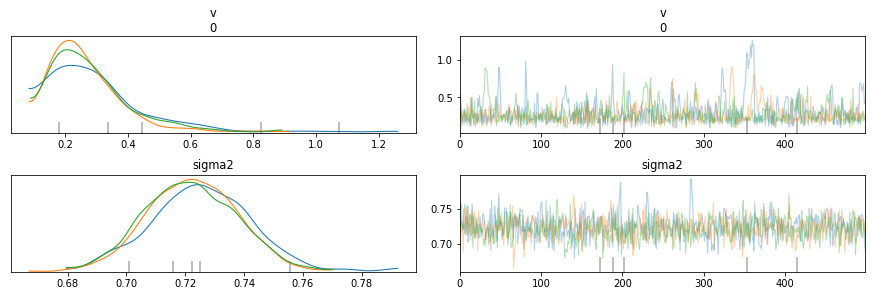

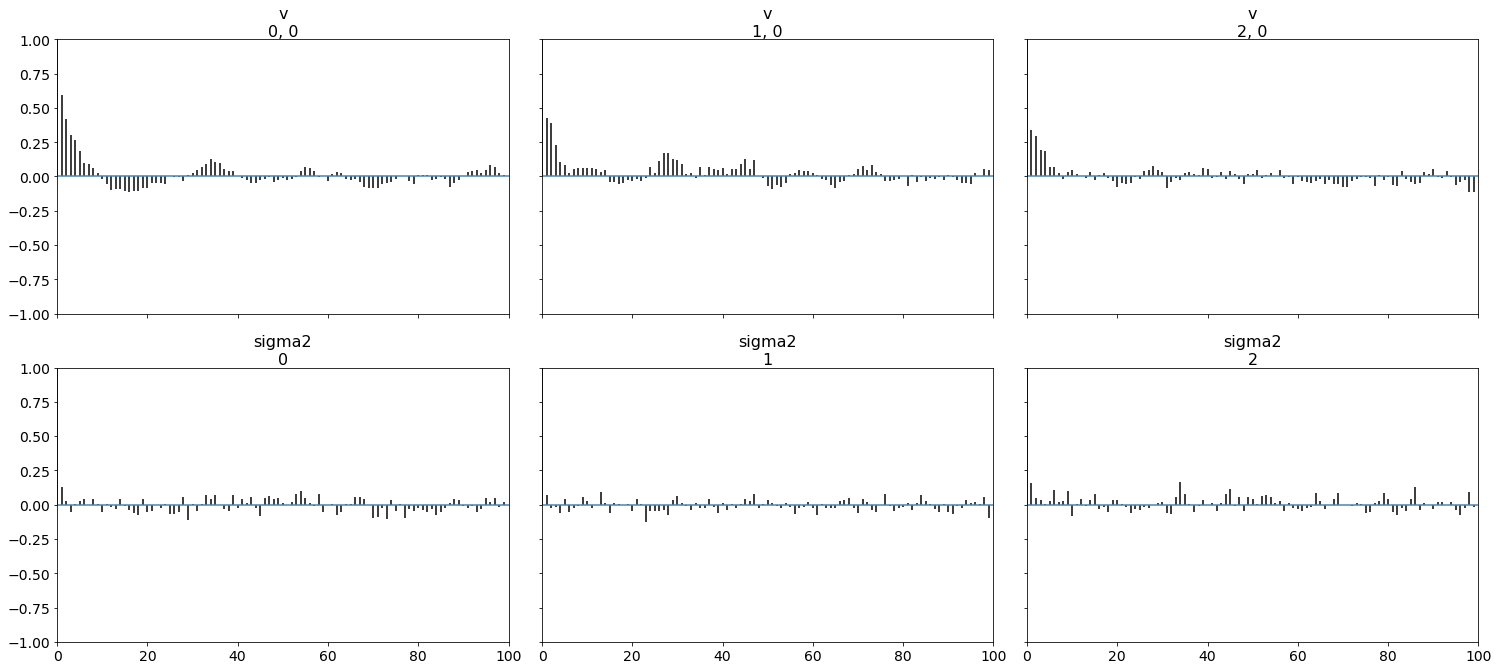

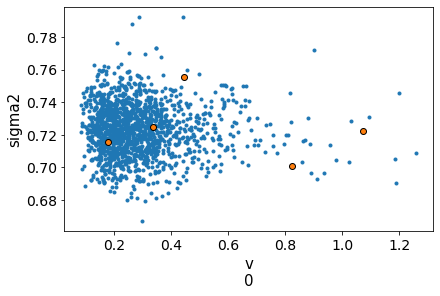

In [28]:
az_v_sigma2_plot(fit_standard2)